# Modelling

## 1. Imports and Reading data

In [3]:
from runner import io 

import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as matplotlib
from scipy.stats import loguniform


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, PowerTransformer, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score,roc_auc_score, accuracy_score, r2_score, mean_squared_error


from sklearn.ensemble import RandomForestRegressor, VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.neural_network import MLPClassifier

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [4]:
# Databricks notebook source
# MAGIC %md # Altair setup

# COMMAND ----------

# MAGIC %sh
# MAGIC # Installing altair
# MAGIC /databricks/python/bin/pip install altair altair_saver selenium -q
# MAGIC 
# MAGIC # Installing chromewebdriver for saving altair plots
# MAGIC apt-get update -y
# MAGIC apt-get install -y chromium-browser chromium-chromedriver

# COMMAND ----------

from datetime import datetime, timedelta
import json

import pandas as pd
import numpy as np

import altair as alt
alt.data_transformers.disable_max_rows()
alt.renderers.set_embed_options(scaleFactor=5)

# COMMAND ----------

# Altair theme setup
def tfg_palette(key="tfg_dark_light"):
    color_schemes = {
        'category-6': ['#ec8431', '#829eb1', '#c89d29', '#3580b1', '#adc839', '#ab7fb4'],
        'fire-7': ['#fbf2c7', '#f9e39c', '#f8d36e', '#f4bb6a', '#e68a4f', '#d15a40', '#ab4232'],
        'fireandice-6': ['#e68a4f', '#f4bb6a', '#f9e39c', '#dadfe2', '#a6b7c6', '#849eae'],
        'ice-7': ['#edefee', '#dadfe2', '#c4ccd2', '#a6b7c6', '#849eae', '#607785', '#47525d'],
        "tfg_dark": ['#0C66B5', '#BA1D32', '#0F8E40', '#E56F20', '#862BAF', '#626D69', '#ED5087'],
        "tfg_light": ['#3DB9E2', '#51DB63', '#E26868', '#FFB270', '#B37CEA', '#A8A1A4', '#FF87CD'],
    }
    
    color_schemes["tfg_dark_light"] = color_schemes["tfg_dark"] + color_schemes["tfg_light"]
    
    return color_schemes[key]

def science_theme_title(
    font="Helvetica Neue",
    titleFontSize=18,
    subtitleFontSize=14,
    titleFontWeight="normal",
    text=None,
    subtitle=None,
    **kwargs
):
    title_dict = {
        "align": "left",
        "anchor": "start",
        "frame": "group",
        "font": font,
        "fontSize": titleFontSize,
        "dy": -2,
        # Doesn't work directly in config
        "subtitleFont": font,
        "subtitleFontSize": subtitleFontSize,
        "fontWeight": titleFontWeight,
    }
    
    if text is not None:
        title_dict["text"] = text

    if subtitle is not None:
        title_dict["subtitle"] = subtitle
    
    if kwargs:
        title_dict.update(kwargs)

    return title_dict

def science_theme(
    width=1600/3,
    height=900/3,
    font="Helvetica Neue",
    titleFontSize=18,
    titleFontWeight="bold",
    subtitleFontSize=14,
    baseFontSize=14,
):    

    return {
        "config": {
            "view": {
                "width": width,
                "height": height,
                "fill": "white",
            },
            "title": science_theme_title(
                font=font,
                titleFontSize=titleFontSize,
                subtitleFontSize=subtitleFontSize,
            ),
            "axis": {
                "domainColor": "lightGrey",
                "gridColor": "lightGrey",
                "gridWidth": 0.25,
#                 "title": None,
                "titleFont": font,
                "titleFontSize": baseFontSize - 3,
                "labelFont": font,
                "labelFontSize": baseFontSize,
            },
            "legend": {
                "layout": {"anchor": "start"},
                "labelLimit": 0,
                "titleFontSize": baseFontSize,
                "titleFont": font,
                "labelFontSize": baseFontSize,
                "labelFont": font,
            },
            "header": {
                "title": None,
                "titleFont": font,
                "labelFont": font,
                "labelFontSize": baseFontSize,
                "labelPadding": 2,
            },
            "range": {
                "category": tfg_palette(),
            },
        }
    }

def science_theme_caption(text):
    return (
        alt.Chart(pd.DataFrame(),
                  title={"text": text, **science_theme_title(titleFontSize=12, titleFontWeight="normal")})
        .mark_text()
        .properties(height=1, view={"stroke": None})
    )

def science_theme_facet_title_background(width, fill="lightGrey", opacity=0.25, widthExtra=1):
    return (
        alt.Chart(pd.DataFrame({"a": [0]}))
        .mark_rect(fill=fill, opacity=opacity)
        .encode(y=alt.value(-25), y2=alt.value(-1), x=alt.value(0), x2=alt.value(width + widthExtra))
    )

def science_theme_facet_plot(chart, 
                             title=None, subtitle=None, caption=None,
                             width=300, height=150,
                             facet_kwargs=None, facet_resolve_scales=None,
                             focus_chart=None, focus_chart_width=300, focus_chart_height=150,
                             focus_chart_title="All",
                             focus_chart_resolve_scales=None,
                             grey_facet_background=True,
                             configure_headerColumn=True,
                             **kwargs):
    
    if facet_kwargs is not None:
        if grey_facet_background:
          chart = (chart + science_theme_facet_title_background(width=width))
        chart = chart.facet(**facet_kwargs)

        if facet_resolve_scales is not None:
          chart = chart.resolve_scale(**facet_resolve_scales)
        
        if focus_chart is not None:
            if grey_facet_background: 
              focus_chart = focus_chart + science_theme_facet_title_background(width=focus_chart_width)
            focus_chart = focus_chart.properties(
                width=focus_chart_width, 
                height=focus_chart_height,
                title=science_theme_title(text=focus_chart_title, titleFontSize=14, anchor="middle", offset=-22 if grey_facet_background else 0)
            )
            chart = focus_chart | chart
            
            if focus_chart_resolve_scales is not None:
              chart = chart.resolve_scale(**focus_chart_resolve_scales)
    
    chart = (
        (chart
         # Adding caption
         & science_theme_caption(caption)).resolve_scale(
            x="independent", y="independent", size="independent",
            color="independent", fill="independent", stroke="independent", opacity="independent",
        )
        # Adding title and subtitle
        .properties(title=science_theme_title(text=title, subtitle=subtitle))
        # Configuring plot size
        .configure_view(width=width, height=height)
    )
    
    if (facet_kwargs is not None) and grey_facet_background and configure_headerColumn:
        chart = chart.configure_headerColumn(labelPadding=-20).configure_headerFacet(labelPadding=-20)
    
    return chart
  
def science_theme_weekly_highlights(format="%b %d", tickCount=40): 
    return alt.Axis(
        format=format,
        tickCount=tickCount,
        gridOpacity=alt.condition(
            alt.Predicate(alt.FieldEqualPredicate(field='value', timeUnit="day", equal=1)),
            alt.value(1.0),
            alt.value(0.4)
        ),
    )
    
alt.themes.register("science_theme", science_theme)
alt.themes.enable("science_theme")

# COMMAND ----------

# DBTITLE 1,Test the saver works with a sample graph save
# import altair_saver
# import pandas as pd

# test_path = '/dbfs/mnt/tfg-ua/airflow/creatives/altair_test_save.png'

# source = pd.DataFrame({'x': ['A'], 'y': [1]})
# chart = alt.Chart(source).mark_bar().encode(x='x', y='y')
# try:
#   chart.save(test_path)
# except ValueError as e:
#   if 'No enabled saver found' in str(e):
#     # retry with an explicit method + driver to provide a more informative error message
#     altair_saver.save(chart, test_path, method='selenium', webdriver='chrome')
#   raise e  # in case the more explicit method works for some reason, or this is an unrecognized error



ThemeRegistry.enable('science_theme')

In [5]:
df = io.load_table("model", "model_df")
# df = df.drop(columns=["city", "location_UF"])
df = df.drop(columns=["location_UF"])

In [6]:
# df = pd.get_dummies(df)
df = df.sort_values("year").reset_index(drop=True)#.drop(columns=["year"])
df

,year,nb_heads_cattle,delta_ha,delta_quantidade_ton,delta_nb_heads,delta_quantidade_ton_cana-de-açúcar,delta_quantidade_ton_milho_(em_grão),delta_quantidade_ton_others_permanente,delta_quantidade_ton_others_temporario,delta_quantidade_ton_soja_(em_grão),...,deforestation_ha_lag_1,nb_heads_cattle_lag_1,deforestation_ha_lag_2,nb_heads_cattle_lag_2,deforestation_ha_lag_3,nb_heads_cattle_lag_3,deforestation_ha_lag_4,nb_heads_cattle_lag_4,deforestation_ha_lag_5,nb_heads_cattle_lag_5
0,1986,513300.0,0.0,0.0,0.0,0.0,312.0,9480.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1986,189300.0,0.0,0.0,0.0,0.0,0.0,0.0,9118.0,2577.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1986,232007.0,0.0,0.0,0.0,62949.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1986,50428.0,0.0,0.0,0.0,0.0,829.0,0.0,0.0,3126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1986,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,2019,160921.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,700.470175,170100.0,1033.625373,163372.0,909.789930,164000.0,761.238831,175104.0,1542.293281,170773.0
540,2019,748882.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,...,4217.975946,807000.0,14213.983949,800827.0,8495.758625,784000.0,10054.906266,775996.0,7682.608841,803976.0
541,2019,518687.0,0.0,0.0,3255.0,0.0,0.0,0.0,250.0,0.0,...,3567.889409,515432.0,3852.025492,516323.0,4125.861237,505084.0,4047.581944,477965.0,6215.411847,446453.0
542,2019,644655.0,0.0,0.0,0.0,0.0,998.0,0.0,54.0,3212.0,...,3839.099412,706576.0,7870.906661,691092.0,8667.792767,698000.0,7874.024910,691915.0,10382.909198,724505.0


In [7]:
df["year"] =df["year"].astype(int)

In [8]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,534,535,536,537,538,539,540,541,542,543
year,1986,1986,1986,1986,1986,1986,1986,1986,1986,1986,...,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019
nb_heads_cattle,513300.0,189300.0,232007.0,50428.0,NaN,527235.0,156275.0,NaN,138132.0,516808.0,...,579306.0,523928.0,334075.0,7808.0,1775028.0,160921.0,748882.0,518687.0,644655.0,524842.0
delta_ha,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
delta_quantidade_ton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
delta_nb_heads,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3255.0,0.0,0.0
delta_quantidade_ton_cana-de-açúcar,0.0,0.0,62949.0,0.0,0.0,18900.0,0.0,0.0,0.0,2360.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
delta_quantidade_ton_milho_(em_grão),312.0,0.0,0.0,829.0,0.0,11415.0,0.0,0.0,930.0,1860.0,...,0.0,3118.0,0.0,3.0,468.0,0.0,60.0,0.0,998.0,0.0
delta_quantidade_ton_others_permanente,9480.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
delta_quantidade_ton_others_temporario,0.0,9118.0,0.0,0.0,0.0,22118.0,0.0,0.0,7574.0,5327.0,...,1500.0,300.0,0.0,0.0,1154.0,0.0,0.0,250.0,54.0,10460.0
delta_quantidade_ton_soja_(em_grão),0.0,2577.0,0.0,3126.0,0.0,0.0,0.0,0.0,0.0,618.0,...,0.0,4315.0,0.0,0.0,0.0,0.0,0.0,0.0,3212.0,0.0


## 2. Modelling

In [9]:
X = df.drop(columns=["deforestation_ha"])
y = df["deforestation_ha"]

In [10]:
X = X.drop(columns=["city", "year"])

In [12]:
cat_vars_complete = [i for i in X .columns if X.dtypes[i] == 'object']
num_vars_complete = [i for i in X.columns if X.dtypes[i] == 'float64' or X.dtypes[i] == 'int64']

ignore_variables = [i for i in num_vars_complete if ("delta" in i or "law" in i or i in ["year"])]
cat_vars = [element for element in cat_vars_complete if (element not in ignore_variables)]
specific_vars = []
num_vars = [element for element in num_vars_complete if (element != 'deforestation_ha' and element not in specific_vars + ignore_variables)]


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), #ver se tem outro que funciona melhor
    ('scaler', StandardScaler()),
#     ('polynomial_features',PolynomialFeatures(interaction_only=True)),
#     ('pca', PCA())
])

specific_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('power_transform', PowerTransformer(method='yeo-johnson')),
#     ('polynomial_features',PolynomialFeatures(interaction_only=False)),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
#     ('truncated_svd', TruncatedSVD())
#     ('sparse_pca', sparse_pca),
#     ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)
    ])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_vars),
        ('cat', categorical_transformer, cat_vars),
#         ('specific', specific_transformer, specific_vars),
    ])


In [176]:
def define_model(cv, type_model="rf", seed=1, random_state=2):
    rf_regressor = RandomForestRegressor(random_state=seed)
    xgb_regressor = XGBRegressor(seed=seed)

    params_xgb = { 'max_depth': [3, 4, 5, 6, 10, 15, 20],
           'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.1, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1, 0.1),
           'colsample_bylevel': np.arange(0.4, 1, 0.1),
           'n_estimators': [100, 400, 500, 600, 1000],
           "max_depth": [None, 1, 2, 3, 4, 5, 6],
           }

    param_dist_rf = {"max_depth": [None, 1, 2],
                "max_features": [1,'sqrt'],
                "min_samples_split": [2, 3, 4, 5],
                "min_samples_leaf": [3, 4, 5, 6],
                "n_estimators": [200, 300, 400, 500, 1000]}


    # best_params_xgboost = {
    #     'subsample': 0.30000000000000004,
    #     'n_estimators': 1000,
    #     'max_depth': 10,
    #     'learning_rate': 0.005,
    #     'colsample_bytree': 0.5,
    #     'colsample_bylevel': 0.8999999999999999
    #     }

    # ((56, 154), 0.7961389170360318)


    rf_random_search = RandomizedSearchCV(rf_regressor, param_distributions=param_dist_rf, scoring="r2",cv=cv, random_state=random_state)
    xgb_random_search = RandomizedSearchCV(xgb_regressor, param_distributions=params_xgb, scoring="r2",cv=cv, random_state=random_state)

    model_rf = Pipeline(
        steps = [
            ('preprocessor', preprocessor),
            ('model', rf_random_search)
            ]
        )

    model_xgb = Pipeline(
        steps = [
            ('preprocessor', preprocessor),
            ('model', xgb_random_search)
            ]
        )

    return model_rf if type_model == "rf" else xgb_random_search

In [128]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=8)
i = 0
# X = X.drop(columns=["year"])
results_list = []
for train_index, test_index in tscv.split(X):
    result_dict = {}
    i += 1
    print("*"*20 + f"SPLIT {i}" + "*"*20)

    # split train test data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    #define model
    model_rf = define_model(tscv.split(X_train), type_model="rf")
    model_xgb = define_model(tscv.split(X_train), type_model="xgb")

    #fit and predict values
    model_xgb.fit(X_train, y_train)
    y_pred = model_xgb.predict(X_test)
    y_train_pred = model_xgb.predict(X_train)

    result_dict["y_pred"] = y_pred
    result_dict["y_test"] = y_test
    result_dict["X_test"] = X_test

    results_list.append(result_dict)
    

    print("-"*20 + "XGBoost" + "-"*20)
    print(f"R2 Score: {r2_score(y_test, y_pred):.2%}")
    # print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
    print(f"R2 Score (Train): {r2_score(y_train, y_train_pred):.2%}")
    print(f"Relative Error: {mean_squared_error(y_test, y_pred, squared=False)/np.mean(y_test):.2%}")

********************SPLIT 1********************
--------------------R.Forest--------------------
R2 Score: 73.74%
R2 Score (Train): 92.51%
Relative Error: 40.46%
********************SPLIT 2********************
--------------------R.Forest--------------------
R2 Score: 62.26%
R2 Score (Train): 93.07%
Relative Error: 52.91%
********************SPLIT 3********************
--------------------R.Forest--------------------
R2 Score: 85.56%
R2 Score (Train): 88.33%
Relative Error: 33.40%
********************SPLIT 4********************
--------------------R.Forest--------------------
R2 Score: 83.49%
R2 Score (Train): 88.94%
Relative Error: 39.67%
********************SPLIT 5********************
--------------------R.Forest--------------------
R2 Score: 87.74%
R2 Score (Train): 88.80%
Relative Error: 32.51%
********************SPLIT 6********************
--------------------R.Forest--------------------
R2 Score: 91.69%
R2 Score (Train): 89.45%
Relative Error: 26.50%
********************SPLIT 7*

In [188]:
import random
results = []
for i in range(50):
    if i == 0:
        seed = 1
        random_state = 2
    elif i == 1:
        seed = 56
        random_state = 154
    elif i == 2:
        seed = 107
        random_state = 3
    else:
        seed = random.randint(1,200)
        random_state = random.randint(1,200)
    model_xgb = define_model(tscv.split(X), type_model="xgb", seed=seed, random_state=random_state)
    model_xgb.fit(X, y)
    # model_xgb["model"].best_params_
    print("*"*50)
    print(f"i={i}")
    print(f"seed: {seed}")
    print(f"random_state: {random_state}")
    # best_result = model_xgb["model"].cv_results_["mean_test_score"].max()
    best_result = model_xgb.cv_results_["mean_test_score"].max()
    results.append(((seed, random_state), best_result))
    print(f"best_result: {best_result}")


**************************************************
i=0
seed: 1
random_state: 2
best_result: 0.7952174785510622
**************************************************
i=1
seed: 56
random_state: 154
best_result: 0.796285067792203
**************************************************
i=2
seed: 107
random_state: 3
best_result: 0.798722177390975
**************************************************
i=3
seed: 95
random_state: 34
best_result: 0.7765394335388609
**************************************************
i=4
seed: 110
random_state: 128
best_result: 0.7886118513402761
**************************************************
i=5
seed: 172
random_state: 144
best_result: 0.7938194947911641
**************************************************
i=6
seed: 82
random_state: 17
best_result: 0.7874312161292147
**************************************************
i=7
seed: 82
random_state: 156
best_result: 0.7683143267150314
**************************************************
i=8
seed: 189
random_state: 136
best_result

In [186]:
max([i[-1] for i in results])

0.798722177390975

In [187]:
[i for i in results if i[-1] > 0.79]

[((1, 2), 0.7952174785510622),
 ((56, 154), 0.796285067792203),
 ((32, 3), 0.7964249713374304),
 ((54, 101), 0.7908707817210161),
 ((30, 42), 0.7908376354050778),
 ((136, 73), 0.7911954795566783),
 ((151, 191), 0.7959815931774692),
 ((189, 150), 0.7937861472258292),
 ((189, 35), 0.7927205999058465),
 ((139, 83), 0.7906837376688962),
 ((107, 3), 0.798722177390975),
 ((71, 193), 0.7909604676692668),
 ((60, 15), 0.7946990784651106),
 ((61, 161), 0.7901092981977327),
 ((27, 103), 0.7929854205718866)]

In [99]:
# model_rf = define_model(tscv.split(X), type_model="rf")
# model_rf.fit(X, y)
# model_rf["model"].best_params_

In [100]:
# model_rf["model"].cv_results_["mean_test_score"].max()

In [131]:
final_prediction_df = pd.DataFrame()
for i in range(8):
    y_pred = results_list[i]["y_pred"]
    y_test = results_list[i]["y_test"]
    X_test = results_list[i]["X_test"]
    # info_place_year_df = X_test.drop(columns=["city"]).join(df[["city", "year"]])[["city", "year"]]
    info_place_year_df = X_test.join(df[["city", "year"]])[["city", "year"]]
    plot_df = pd.DataFrame(
    {
        "city": info_place_year_df["city"], 
        "year": info_place_year_df["year"], 
        "y_pred": y_pred,
        "y_test": y_test,
        "cv": str(i),
        "r2_score": r2_score(y_test, y_pred)
    })
    final_prediction_df = pd.concat([final_prediction_df, plot_df])

# final_prediction_df["r2_by_city"] = final_prediction_df.groupby("city").transform()
final_prediction_df["year"] = pd.to_datetime(final_prediction_df["year"], format="%Y")
final_prediction_df.head()

,city,year,y_pred,y_test,cv,r2_score
64,Barão de Melgaço,1990-01-01,1707.478638,1529.765288,0,0.737392
65,Santo Antônio do Leverger,1990-01-01,4565.208984,4131.878732,0,0.737392
66,Poconé,1990-01-01,4137.582031,4243.028325,0,0.737392
67,Nossa Senhora do Livramento,1990-01-01,4312.276367,4465.019085,0,0.737392
68,Lambari D'Oeste,1990-01-01,2427.886963,2193.899785,0,0.737392


In [132]:
# final_prediction_df["r2_by_city"] = final_prediction_df.groupby("city").apply(lambda x: r2_score(x["y_test"], x["y_pred"]))
# final_prediction_df

In [133]:
line_chart_pred = alt.Chart(final_prediction_df).mark_line(color="orange").encode(
    x=alt.X('year:T', axis = alt.Axis(format="%Y")),
    y='y_pred:Q',
#     strokeDash='type'
)

line_chart_test = alt.Chart(final_prediction_df).mark_line(color="blue", opacity=0.6).encode(
    x=alt.X('year:T', axis = alt.Axis(format="%Y")),
    y='y_test:Q',
#     strokeDash='type'
)

combined_chart = line_chart_pred + line_chart_test

combined_chart.properties(
    width=200,
    height=200
).facet(
    'city:N',
    columns=4
).resolve_axis(
    # x='independent',
    # y='independent'
).resolve_scale(
    # x='independent',
    # y='independent'
)


alt.FacetChart(...)

In [134]:
final_prediction_df_w_index = final_prediction_df.reset_index()
final_prediction_df_w_index["r2_score_text"] = "R² = " + final_prediction_df_w_index["r2_score"].apply(lambda x: f"{x*100:.3}%")
final_prediction_df_w_index["cv"] = final_prediction_df_w_index["cv"].astype(int) + 1
final_prediction_df_w_index["cv_text"] = "CV iteration = " + (final_prediction_df_w_index["cv"]).astype(str)
final_prediction_df_w_index

,index,city,year,y_pred,y_test,cv,r2_score,r2_score_text,cv_text
0,64,Barão de Melgaço,1990-01-01,1707.478638,1529.765288,1,0.737392,R² = 73.7%,CV iteration = 1
1,65,Santo Antônio do Leverger,1990-01-01,4565.208984,4131.878732,1,0.737392,R² = 73.7%,CV iteration = 1
2,66,Poconé,1990-01-01,4137.582031,4243.028325,1,0.737392,R² = 73.7%,CV iteration = 1
3,67,Nossa Senhora do Livramento,1990-01-01,4312.276367,4465.019085,1,0.737392,R² = 73.7%,CV iteration = 1
4,68,Lambari D'Oeste,1990-01-01,2427.886963,2193.899785,1,0.737392,R² = 73.7%,CV iteration = 1
...,...,...,...,...,...,...,...,...,...
475,539,Bodoquena,2019-01-01,1536.715088,768.205690,8,0.524980,R² = 52.5%,CV iteration = 8
476,540,Aquidauana,2019-01-01,8189.743164,5271.394814,8,0.524980,R² = 52.5%,CV iteration = 8
477,541,Poconé,2019-01-01,5321.387207,1667.153113,8,0.524980,R² = 52.5%,CV iteration = 8
478,542,Porto Murtinho,2019-01-01,8080.914551,5374.861069,8,0.524980,R² = 52.5%,CV iteration = 8


In [135]:

from string import whitespace


line_chart_pred = alt.Chart(final_prediction_df_w_index).mark_line(color="orange", opacity=0.8).encode(
    x=alt.X('index:Q'),
    y='y_pred:Q',
#     strokeDash='type'
)

# point_chart_pred = alt.Chart(final_prediction_df_w_index).mark_point(color="orange", opacity=0.8, size=10, filled=False).encode(
#     x=alt.X('index:T', axis = alt.Axis(format="%d")),
#     y='y_pred:Q',
# #     strokeDash='type'
# )

line_chart_test = alt.Chart(final_prediction_df_w_index).mark_line(color="blue", opacity=0.5).encode(
    x=alt.X('index:Q'),
    y='y_test:Q',
)

r2_score_text = alt.Chart(final_prediction_df_w_index).mark_text(
    align="left", baseline="top", size=13, color='green', opacity=0.7
).encode(
    x=alt.value(20),  # pixels from left
    y=alt.value(20),  # pixels from top
    text="r2_score_text")

combined_chart = line_chart_pred + line_chart_test + r2_score_text

combined_chart.properties(
    width=450,
    height=250
).facet(
    'cv_text',
    columns=2
).resolve_scale(
    x='independent', 
    # y='independent'
)


alt.FacetChart(...)

In [66]:
# cv_res = model_rf["model"].cv_results_
# for r2, params in zip(cv_res["mean_test_score"], cv_res["params"]):
#     print(r2, params)

## 3. Interpreting the model

In [137]:
import shap
# Fits the explainer
explainer = shap.Explainer(model_xgb.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

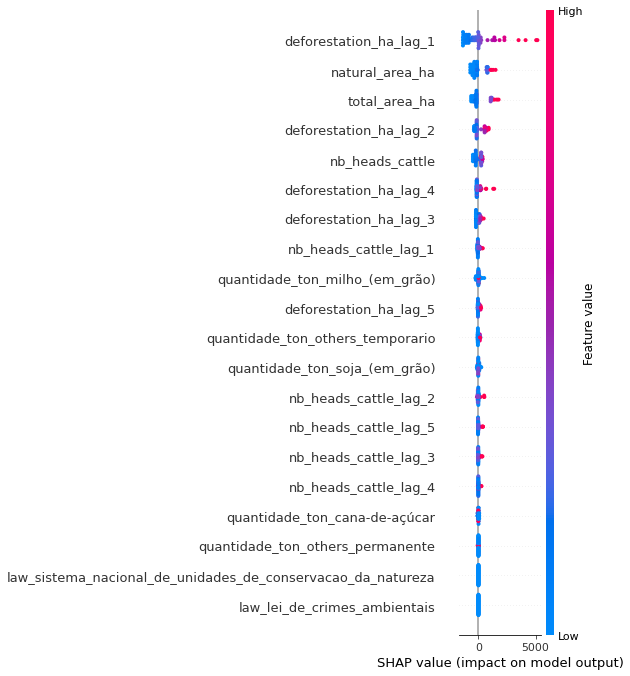

In [138]:
shap.summary_plot(shap_values)

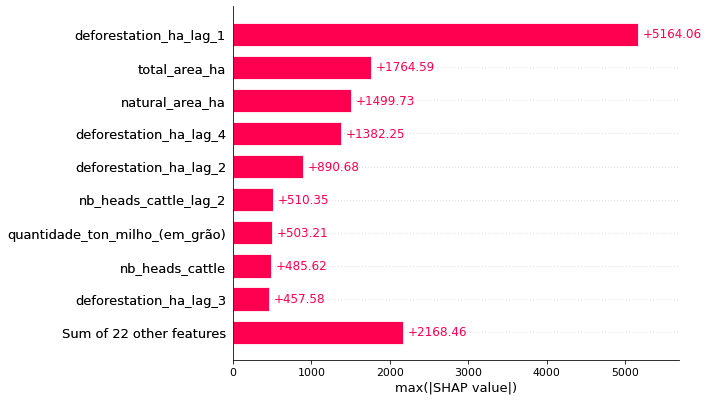

In [142]:
shap.plots.bar(shap_values.abs.max(0))

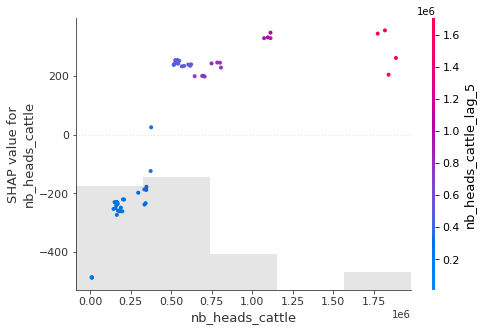

In [143]:
shap.plots.scatter(shap_values[:,"nb_heads_cattle"], color=shap_values)


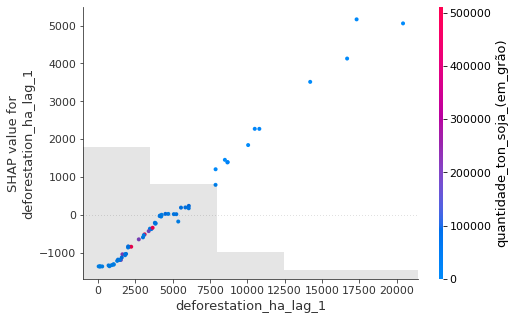

In [144]:
shap.plots.scatter(shap_values[:,"deforestation_ha_lag_1"], color=shap_values)


In [76]:
import pandas as pd
df = pd.read_clipboard()

In [77]:
df.to_level_4.unique()

AttributeError: 'DataFrame' object has no attribute 'to_level_4'

<AxesSubplot:>

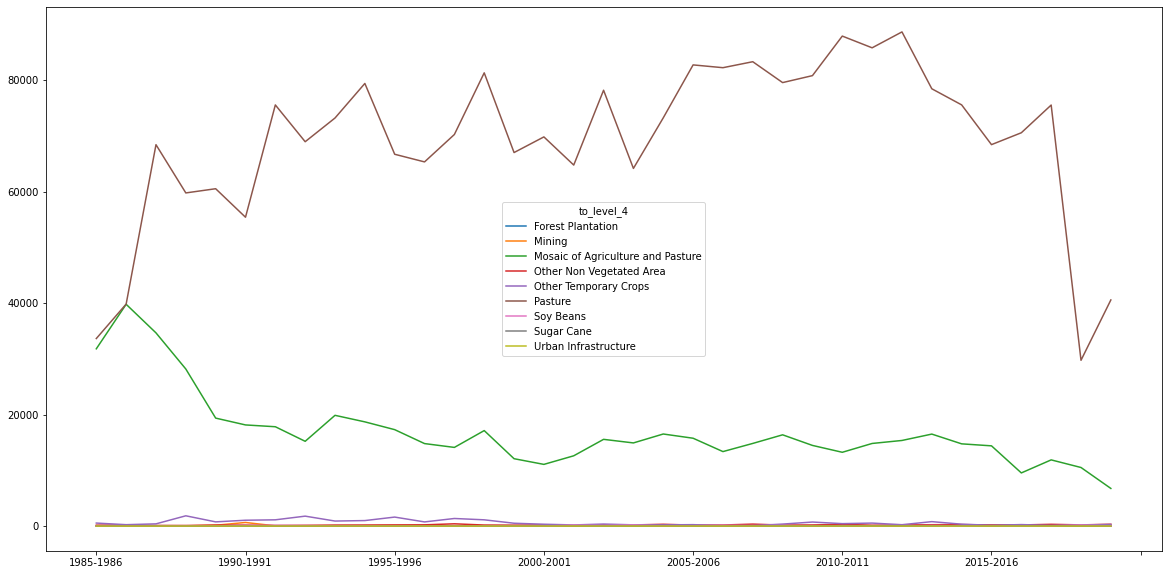

In [ ]:
df.query("to_level_0 == 'Anthropic' and from_level_0 != 'Anthropic'").groupby("to_level_4").sum().T.plot(figsize=(20,10))

In [ ]:
melted_df

,city,state,location,from_level_0,from_level_1,from_level_2,from_level_3,from_level_4,to_level_0,to_level_1,to_level_2,to_level_3,to_level_4,year,deforestation_ha
0,Aquidauana,MS,Aquidauana (MS),Natural,1. Forest,Forest Formation,Forest Formation,Forest Formation,Anthropic,3. Farming,Pasture,Pasture,Pasture,1985-1986,800.483673
1,Aquidauana,MS,Aquidauana (MS),Natural,1. Forest,Forest Formation,Forest Formation,Forest Formation,Anthropic,3. Farming,Agriculture,Temporary Crops,Soy Beans,1985-1986,NaN
2,Aquidauana,MS,Aquidauana (MS),Natural,1. Forest,Forest Formation,Forest Formation,Forest Formation,Anthropic,3. Farming,Agriculture,Temporary Crops,Sugar Cane,1985-1986,NaN
3,Aquidauana,MS,Aquidauana (MS),Natural,1. Forest,Forest Formation,Forest Formation,Forest Formation,Anthropic,3. Farming,Agriculture,Temporary Crops,Other Temporary Crops,1985-1986,NaN
4,Aquidauana,MS,Aquidauana (MS),Natural,1. Forest,Forest Formation,Forest Formation,Forest Formation,Anthropic,3. Farming,Forest Plantation,Forest Plantation,Forest Plantation,1985-1986,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17005,Santo Antônio do Leverger,MT,Santo Antônio do Leverger (MT),Natural,5. Water,"River, Lake and Ocean","River, Lake and Ocean","River, Lake and Ocean",Anthropic,3. Farming,Agriculture,Temporary Crops,Soy Beans,2019-2020,NaN
17006,Santo Antônio do Leverger,MT,Santo Antônio do Leverger (MT),Natural,5. Water,"River, Lake and Ocean","River, Lake and Ocean","River, Lake and Ocean",Anthropic,3. Farming,Agriculture,Temporary Crops,Other Temporary Crops,2019-2020,NaN
17007,Santo Antônio do Leverger,MT,Santo Antônio do Leverger (MT),Natural,5. Water,"River, Lake and Ocean","River, Lake and Ocean","River, Lake and Ocean",Anthropic,3. Farming,Mosaic of Agriculture and Pasture,Mosaic of Agriculture and Pasture,Mosaic of Agriculture and Pasture,2019-2020,0.086100
17008,Santo Antônio do Leverger,MT,Santo Antônio do Leverger (MT),Natural,5. Water,"River, Lake and Ocean","River, Lake and Ocean","River, Lake and Ocean",Anthropic,4. Non Vegetated Area,Urban Infrastructure,Urban Infrastructure,Urban Infrastructure,2019-2020,NaN
